### Import the required libraries and modules:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/Chase2

Mounted at /content/gdrive
/content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/Chase2


### Unzip the data:

In [ ]:
# !unzip new_data.zip

### Construct the Model:

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters, strides=2):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D(strides)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, strides=2):
    x = Conv2DTranspose(num_filters, (2, 2), strides=strides, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2]):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters[0], strides=strides[0])
    s2, p2 = encoder_block(p1, num_filters[1], strides=strides[1])
    s3, p3 = encoder_block(p2, num_filters[2], strides=strides[2])
    s4, p4 = encoder_block(p3, num_filters[3], strides=strides[3])

    b1 = conv_block(p4, num_filters[4])

    d1 = decoder_block(b1, s4, num_filters[3], strides=strides[3])
    d2 = decoder_block(d1, s3, num_filters[2], strides=strides[2])
    d3 = decoder_block(d2, s2, num_filters[1], strides=strides[1])
    d4 = decoder_block(d3, s1, num_filters[0], strides=strides[0])

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

### Adding the Metrics:

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def DiceBCELoss(y_true, y_pred):

    inputs = tf.keras.layers.Flatten()(y_true)
    targets = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(inputs * targets)
    dice_loss = 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    BCE = tf.keras.losses.BinaryCrossentropy()
    Dice_BCE = BCE(inputs, targets) + dice_loss

    return Dice_BCE



### Training the Model:

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 4
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model1.h5")
csv_path = os.path.join("files", "data1.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model1 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 384], strides=[1, 2, 2, 2])

model1.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model1.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.0694 - dice_coef: 0.2867 - iou: 0.1695 - recall: 0.6379 - precision: 0.4022
Epoch 1: val_loss improved from inf to 1.52171, saving model to files/model1.h5
35/35 [==============================] - 173s 3s/step - loss: 1.0694 - dice_coef: 0.2867 - iou: 0.1695 - recall: 0.6379 - precision: 0.4022 - val_loss: 1.5217 - val_dice_coef: 0.1094 - val_iou: 0.0579 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 0.7590 - dice_coef: 0.4408 - iou: 0.2833 - recall: 0.6931 - precision: 0.7087
Epoch 2: val_loss improved from 1.52171 to 1.36106, saving model to files/model1.h5
35/35 [==============================] - 106s 3s/step - loss: 0.7590 - dice_coef: 0.4408 - iou: 0.2833 - recall: 0.6931 - precision: 0.7087 - val_loss: 1.3611 - val_dice_coef: 0.1033 - val_iou: 0.0545 - val_recall: 0.0000e+00 - val_precision: 

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model2.h5")
csv_path = os.path.join("files", "data2.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model2 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 512], strides=[1, 2, 2, 2])

model2.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model2.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.9362 - dice_coef: 0.3528 - iou: 0.2179 - recall_2: 0.6667 - precision_2: 0.4957
Epoch 1: val_loss improved from inf to 1.34827, saving model to files/model2.h5
70/70 [==============================] - 124s 1s/step - loss: 0.9362 - dice_coef: 0.3528 - iou: 0.2179 - recall_2: 0.6667 - precision_2: 0.4957 - val_loss: 1.3483 - val_dice_coef: 0.1032 - val_iou: 0.0544 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.6595 - dice_coef: 0.5052 - iou: 0.3387 - recall_2: 0.7137 - precision_2: 0.7660
Epoch 2: val_loss improved from 1.34827 to 1.19380, saving model to files/model2.h5
70/70 [==============================] - 99s 1s/step - loss: 0.6595 - dice_coef: 0.5052 - iou: 0.3387 - recall_2: 0.7137 - precision_2: 0.7660 - val_loss: 1.1938 - val_dice_coef: 0.0867 - val_iou: 0.0453 - val_recall_2: 0.0000e

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model3.h5")
csv_path = os.path.join("files", "data3.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model3 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 768], strides=[1, 2, 2, 2])

model3.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model3.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.9356 - dice_coef: 0.3537 - iou: 0.2186 - recall_3: 0.6670 - precision_3: 0.4956
Epoch 1: val_loss improved from inf to 1.34742, saving model to files/model3.h5
70/70 [==============================] - 108s 1s/step - loss: 0.9356 - dice_coef: 0.3537 - iou: 0.2186 - recall_3: 0.6670 - precision_3: 0.4956 - val_loss: 1.3474 - val_dice_coef: 0.1028 - val_iou: 0.0542 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.6628 - dice_coef: 0.5036 - iou: 0.3373 - recall_3: 0.7153 - precision_3: 0.7645
Epoch 2: val_loss improved from 1.34742 to 1.20412, saving model to files/model3.h5
70/70 [==============================] - 104s 1s/step - loss: 0.6628 - dice_coef: 0.5036 - iou: 0.3373 - recall_3: 0.7153 - precision_3: 0.7645 - val_loss: 1.2041 - val_dice_coef: 0.0875 - val_iou: 0.0458 - val_recall_3: 0.0000

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model4.h5")
csv_path = os.path.join("files", "data4.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model4 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[1, 2, 2, 2])

model4.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model4.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.9327 - dice_coef: 0.3553 - iou: 0.2198 - recall: 0.6670 - precision: 0.4973
Epoch 1: val_loss improved from inf to 1.34515, saving model to files/model4.h5
70/70 [==============================] - 159s 2s/step - loss: 0.9327 - dice_coef: 0.3553 - iou: 0.2198 - recall: 0.6670 - precision: 0.4973 - val_loss: 1.3452 - val_dice_coef: 0.1028 - val_iou: 0.0542 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.6559 - dice_coef: 0.5077 - iou: 0.3410 - recall: 0.7160 - precision: 0.7687
Epoch 2: val_loss improved from 1.34515 to 1.22295, saving model to files/model4.h5
70/70 [==============================] - 111s 2s/step - loss: 0.6559 - dice_coef: 0.5077 - iou: 0.3410 - recall: 0.7160 - precision: 0.7687 - val_loss: 1.2230 - val_dice_coef: 0.0942 - val_iou: 0.0495 - val_recall: 0.0000e+00 - val_precision: 

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 1
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model5.h5")
csv_path = os.path.join("files", "data5.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model5 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1280], strides=[1, 2, 2, 2])

model5.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model5.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 0.8329 - dice_coef: 0.4098 - iou: 0.2631 - recall_1: 0.6740 - precision_1: 0.5835
Epoch 1: val_loss improved from inf to 1.18397, saving model to files/model5.h5
140/140 [==============================] - 144s 881ms/step - loss: 0.8329 - dice_coef: 0.4098 - iou: 0.2631 - recall_1: 0.6740 - precision_1: 0.5835 - val_loss: 1.1840 - val_dice_coef: 0.0826 - val_iou: 0.0431 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 0.5829 - dice_coef: 0.5587 - iou: 0.3891 - recall_1: 0.7199 - precision_1: 0.8102
Epoch 2: val_loss improved from 1.18397 to 1.17487, saving model to files/model5.h5
140/140 [==============================] - 127s 904ms/step - loss: 0.5829 - dice_coef: 0.5587 - iou: 0.3891 - recall_1: 0.7199 - precision_1: 0.8102 - val_loss: 1.1749 - val_dice_coef: 0.0648 - val_iou: 0.0335 - val_re

### Evaluating the Model:

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.models import load_model

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model1.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score1 = [s[1:] for s in SCORE]
score1 = np.mean(score1, axis=0)
print(f"Accuracy: {score1[0]:0.5f}")
print(f"F1: {score1[1]:0.5f}")
print(f"Jaccard: {score1[2]:0.5f}")
print(f"Recall: {score1[3]:0.5f}")
print(f"Precision: {score1[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score1.csv")

100%|██████████| 8/8 [00:35<00:00,  4.40s/it]


Accuracy: 0.97118
F1: 0.74272
Jaccard: 0.59109
Recall: 0.84816
Precision: 0.66420


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model2.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score2 = [s[1:] for s in SCORE]
score2 = np.mean(score2, axis=0)
print(f"Accuracy: {score2[0]:0.5f}")
print(f"F1: {score2[1]:0.5f}")
print(f"Jaccard: {score2[2]:0.5f}")
print(f"Recall: {score2[3]:0.5f}")
print(f"Precision: {score2[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score2.csv")

100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Accuracy: 0.97156
F1: 0.74864
Jaccard: 0.59859
Recall: 0.86434
Precision: 0.66269


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model3.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score3 = [s[1:] for s in SCORE]
score3 = np.mean(score3, axis=0)
print(f"Accuracy: {score3[0]:0.5f}")
print(f"F1: {score3[1]:0.5f}")
print(f"Jaccard: {score3[2]:0.5f}")
print(f"Recall: {score3[3]:0.5f}")
print(f"Precision: {score3[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score3.csv")

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Accuracy: 0.96774
F1: 0.72701
Jaccard: 0.57136
Recall: 0.87535
Precision: 0.62309


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model4.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score4 = [s[1:] for s in SCORE]
score4 = np.mean(score4, axis=0)
print(f"Accuracy: {score4[0]:0.5f}")
print(f"F1: {score4[1]:0.5f}")
print(f"Jaccard: {score4[2]:0.5f}")
print(f"Recall: {score4[3]:0.5f}")
print(f"Precision: {score4[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score4.csv")

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Accuracy: 0.97255
F1: 0.75273
Jaccard: 0.60383
Recall: 0.85300
Precision: 0.67649


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model5.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score5 = [s[1:] for s in SCORE]
score5 = np.mean(score5, axis=0)
print(f"Accuracy: {score5[0]:0.5f}")
print(f"F1: {score5[1]:0.5f}")
print(f"Jaccard: {score5[2]:0.5f}")
print(f"Recall: {score5[3]:0.5f}")
print(f"Precision: {score5[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score5.csv")

100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Accuracy: 0.97240
F1: 0.74157
Jaccard: 0.59037
Recall: 0.81574
Precision: 0.68619


In [ ]:
""" Save the results in this folder """
create_dir("results75")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model4.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.75
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results75/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score4 = [s[1:] for s in SCORE]
score4 = np.mean(score4, axis=0)
print(f"Accuracy: {score4[0]:0.5f}")
print(f"F1: {score4[1]:0.5f}")
print(f"Jaccard: {score4[2]:0.5f}")
print(f"Recall: {score4[3]:0.5f}")
print(f"Precision: {score4[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score75.csv")

100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


Accuracy: 0.97416
F1: 0.75830
Jaccard: 0.61112
Recall: 0.82807
Precision: 0.70307


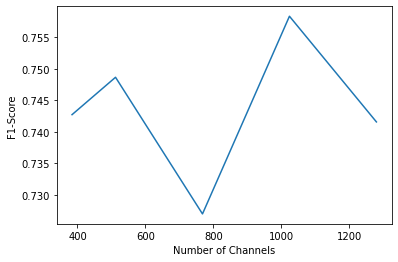

In [ ]:
import matplotlib.pyplot as plt

z_dim = 64
channels = [384, 512, 768, 1024, 1280]
final_score = [score1[1], score2[1], score3[1], score4[1], score5[1]]

plt.plot(channels, final_score)  
plt.xlabel("Number of Channels")
plt.ylabel("F1-Score")
plt.show()  